In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

# Facial Filters

Using your trained facial keypoint detector, you can now do things like add filters to a person's face, automatically. In this optional notebook, you can play around with adding sunglasses to detected face's in an image by using the keypoints detected around a person's eyes. Checkout the `images/` directory to see what pther .png's have been provided for you to try, too!

<img src="images/face_filter_ex.png" width=60% height=60%/>

Let's start this process by looking at a sunglasses .png that we'll be working with!

In [3]:
# import necessary resources
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2

Image shape:  (1123, 3064, 4)


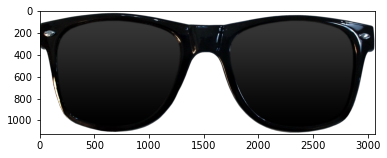

In [4]:
# load in sunglasses image with cv2 and IMREAD_UNCHANGED
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)

# plot our image
plt.imshow(sunglasses)

# print out its dimensions
print('Image shape: ', sunglasses.shape)

## The 4th dimension

You'll note that this image actually has *4 color channels*, not just 3 as your avg RGB image does. This is due to the flag we set `cv2.IMREAD_UNCHANGED`, which tells this to read in another color channel.

#### Alpha channel
It has the usual red, blue, and green channels any color image has, and the 4th channel respresents the **transparency level of each pixel** in the image; this is often called the **alpha** channel. Here's how the transparency channel works: the lower the value, the more transparent, or see-through, the pixel will become.  The lower bound (completely transparent) is zero here, so any pixels set to 0 will not be seen; these look like white background pixels in the image above, but they are actually totally transparent. 

This transparent channel allows us to place this rectangular image of sunglasses on an image of a face and still see the face area that is techically covered by the transparentbackground of the sunglasses image!

Let's check out the alpha channel of our sunglasses image in the next Python cell. Because many of the pixels in the background of the image have an alpha value of 0, we'll need to explicitly print out non-zero values if we want to see them.

The alpha channel looks like this (black pixels = transparent): 


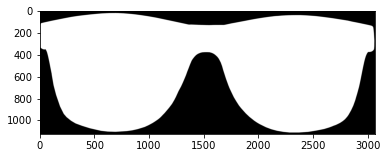

In [5]:
# print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('The alpha channel looks like this (black pixels = transparent): ')
plt.imshow(alpha_channel, cmap='gray')

In [6]:
# just to double check that there are indeed non-zero values
# let's find and print out every value greater than zero
values = np.where(alpha_channel != 0)
print ('The non-zero values of the alpha channel are: ')
print (values)

The non-zero values of the alpha channel are: 
(array([  17,   17,   17, ..., 1109, 1109, 1109]), array([ 687,  688,  689, ..., 2376, 2377, 2378]))


#### Overlaying images

This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter:

* If the pixels are non-transparent (alpha_channel > 0), overlay them on the new image

#### Keypoint locations

In doing this, it's helpful to understand which keypoint belongs to the eyes, mouth, etc., so in the image below we also print the index of each facial keypoint directly on the image so you can tell which keypoints are for the eyes, eyebrows, etc.,

<img src="images/landmarks_numbered.jpg" width=50% height=50%/>

It may be useful to use keypoints that correspond to the edges of the face to define the width of the sunglasses, and the locations of the eyes to define the placement.

Next, we'll load in an example image. Below, you've been given an image and set of keypoints from the provided training set of data, but you can use your own CNN model to generate keypoints for *any* image of a face (as in Notebook 3) and go through the same overlay process!

In [7]:
# load in training data
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


In [8]:
# helper function to display keypoints
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')


Image name:  Christopher_Walken_01.jpg


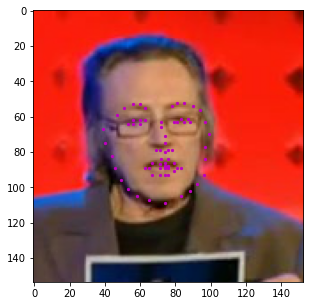

In [9]:
# a selected image
n = 120
image_name = key_pts_frame.iloc[n, 0]
image = mpimg.imread(os.path.join('data/training/', image_name))
key_pts = key_pts_frame.iloc[n, 1:].values.astype('float').reshape(-1, 2)

print('Image name: ', image_name)

plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)
plt.show()

Next, you'll see an example of placing sunglasses on the person in the loaded image.

Note that the keypoints are numbered off-by-one in the numbered image above, and so `key_pts[0,:]` corresponds to the first point (1) in the labelled image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


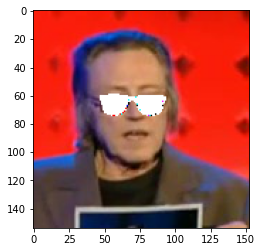

In [10]:
# Display sunglasses on top of the image in the appropriate place

# copy of the face image for overlay
image_copy = np.copy(image)

# top-left location for sunglasses to go
# 17 = edge of left eyebrow
x = int(key_pts[17, 0])
y = int(key_pts[17, 1])

# height and width of sunglasses
# h = length of nose
h = int(abs(key_pts[27,1] - key_pts[34,1]))
# w = left to right eyebrow edges
w = int(abs(key_pts[17,0] - key_pts[26,0]))

# read in sunglasses
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)
# resize sunglasses
new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

# get region of interest on the face to change
roi_color = image_copy[y:y+h,x:x+w]

# find all non-transparent pts
ind = np.argwhere(new_sunglasses[:,:,3] > 0)

# for each non-transparent point, replace the original image pixel with that of the new_sunglasses
for i in range(3): roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
# set the area of the image to the changed region with sunglasses
image_copy[y:y+h,x:x+w] = roi_color


# display the result!
plt.imshow(image_copy)

# Further steps

Look in the `images/` directory to see other available .png's for overlay! Also, you may notice that the overlay of the sunglasses is not entirely perfect; you're encouraged to play around with the scale of the width and height of the glasses and investigate how to perform [image rotation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html) in OpenCV so as to match an overlay with any facial pose.

## Overlay perfect Filters

### Helper

In [11]:
# Using https://github.com/jrosebr1/imutils and https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/
# I saw that we can have a good idea of the angle to which display the filter by looking at the eyes

# compute the center of mass for each eye
def getAngleImage(shape):
    from collections import OrderedDict
    
    FACIAL_LANDMARKS_5_IDXS = OrderedDict([
      ("right_eye", (42, 47)),
      ("left_eye", (36, 41)),
      ("nose", (27, 35))
    ])
  
    (lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
    (rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]
    
    leftEyePts = shape[lStart:lEnd]
    rightEyePts = shape[rStart:rEnd]
    
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
    
    # compute the angle between the eye centroids
    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX))

    return angle

# Choose image with tilted head to make sure angle is being calculated
n = 695
image_name = key_pts_frame.iloc[n, 0]
image = mpimg.imread(os.path.join('data/training/', image_name))
key_pts = key_pts_frame.iloc[n, 1:].values.astype('float').reshape(-1, 2)


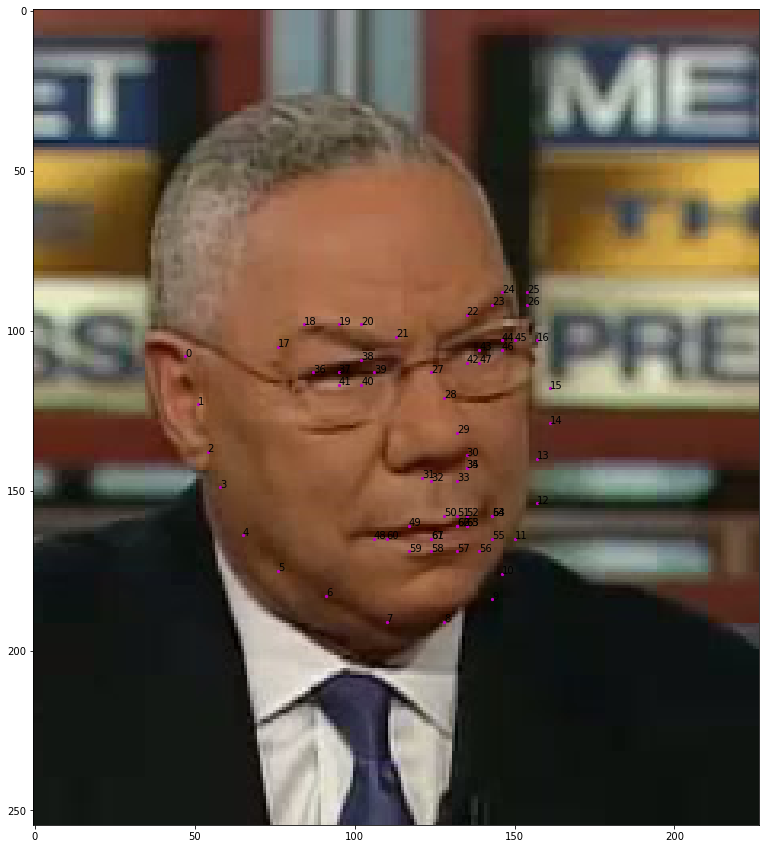

In [12]:
def plotFilterInImage(image, filterpath, x, y, h, w):
  image_copy = np.copy(image)

  filter = cv2.imread(filterpath, cv2.IMREAD_UNCHANGED)
  new_filter =  cv2.resize(filter, (w, h), interpolation = cv2.INTER_CUBIC)
  
  # Rotate picture according to angle of face
  angle = getAngleImage(key_pts)
  M = cv2.getRotationMatrix2D((w//2,h//2), -angle, 1)
  new_filter = cv2.warpAffine(new_filter, M, (w, h))

  roi_color = image_copy[y:y+h,x:x+w]
  ind = np.argwhere(new_filter[:,:,3] > 0)
  for i in range(3): roi_color[ind[:,0],ind[:,1],i] = new_filter[ind[:,0],ind[:,1],i]    

  image_copy[y:y+h,x:x+w] = roi_color
  plt.imshow(image_copy)

# helper function to display keypoints
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111)
    plt.imshow(image)
    ax.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
    for i, (x,y) in enumerate(zip(key_pts[:, 0], key_pts[:, 1])):
      ax.annotate(i, (x, y))
    plt.show()

show_keypoints(image, key_pts)

### Sunglasses

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


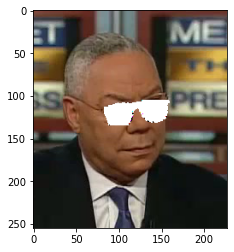

In [13]:
x_glasses, y_glasses = int(key_pts[17, 0]*1.1), int(key_pts[17, 1])
h_glasses, w_glasses = int(abs(key_pts[27,1] - key_pts[34,1])), int(abs(key_pts[17,0] - key_pts[26,0]))
plotFilterInImage(image, 'images/sunglasses.png', x_glasses, y_glasses, h_glasses, w_glasses)

### Mustache

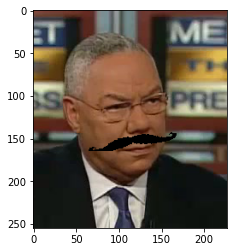

In [14]:
x_mustache, y_mustache = int(key_pts[4, 0]), int(key_pts[34, 1])
h_mustache, w_mustache = int(abs(key_pts[63,1] - key_pts[30,1])), int(abs(key_pts[3,0] - key_pts[14,0]))
plotFilterInImage(image, 'images/moustache.png', x_mustache, y_mustache, h_mustache, w_mustache)

### Hat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


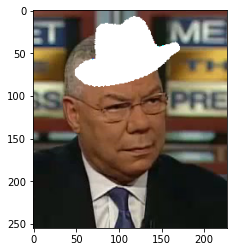

In [15]:
x_hat, y_hat = int(key_pts[0, 0] * 0.7), 0
h_hat, w_hat = int(min(key_pts[:,1])*1.1), int(abs(key_pts[0,0] - key_pts[16,0]) * 1.4)
plotFilterInImage(image, 'images/straw_hat.png', x_hat, y_hat, h_hat, w_hat)

## Smile Detection

In [16]:
def getMouthCurvature(n):
    from scipy.optimize import curve_fit
    from math import pi, cos, sin
    
    def func1(x, a, b, c):
        return a*x**2+b*x+c

    image = cv2.imread(os.path.join('data/training/', key_pts_frame.iloc[n, 0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    key_pts = key_pts_frame.iloc[n, 1:].values.astype('float').reshape(-1, 2)
    mouth = key_pts[54:60]
    angle = getAngleImage(key_pts)
    
    # get points from mouth sorted by X
    x, y = sorted(mouth[:, 0]), [a for _, a in sorted(zip(mouth[:, 0], mouth[:, 1]))]
    
    # find a curve that best describe the mouth
    popt, pcov = curve_fit(func1, x, y)
    a, b, c = popt[0], popt[1], popt[2]
    y = np.array([int(func1(x1, a, b, c)) for x1 in x ])
    x = np.array(x)

    # Formula found in: 
    # http://danceswithcode.net/engineeringnotes/rotations_in_2d/rotations_in_2d.html
    #x1 = (x0 – xc)cos(θ) – (y0 – yc)sin(θ) + xc
    #y1 = (x0 – xc)sin(θ) + (y0 – yc)cos(θ) + yc
    x_rotated  = (x - x[0]) * cos(-angle * pi / 180) - (y - y[0]) * sin(-angle * pi / 180) + x[0]
    y_rotated  = (x - x[0]) * sin(-angle * pi / 180) + (y - y[0]) * cos(-angle * pi / 180) + y[0]
    
    x_rotated = list(map(int, x_rotated))
    y_rotated = list(map(int, y_rotated)) 
    return image, mouth, x, y, x_rotated, y_rotated

In [17]:
# 4 possible outcomes: Big Smile | Smiling | Neutral | Sad
def getSmile(x, y):
    BIGSMILE, SMILE  = "BigSmile: \U0001F600", "Smile: \U0001F642"
    NEUTRAL, SAD = "Neutral: \U0001F611", "Sad: \U0001F610"
    threshold_smile, bigsmilethreshold = 4, 6 #pixels
    # get the extreme measurements of mouth and then the upper and lower point from mouth
    leftmost, rightmost = (x[0], y[0]), (x[-1], y[-1])
    # find the center of the main line of mouth
    centerpoint = ((rightmost[0] + leftmost[0]) // 2 , 
                   (rightmost[1] + leftmost[1]) // 2)
    # get the lowest point of the curve
    i_lower = np.argwhere(np.array(y) == max(y)).ravel()[0]
    # get the highest point of the curve
    i_higher = np.argwhere(np.array(y) == min(y)).ravel()[0]
    upperpoint, lowerpoint = (x[i_higher], y[i_higher]), (x[i_lower], y[i_lower])
    
    # calculate the distance from highest point of the curve to center
    highest_center = abs(upperpoint[1] - max(rightmost[1], leftmost[1]))
    # calculate the distance from lowest point of the curve to center
    lowest_center = abs(lowerpoint[1] - min(rightmost[1], leftmost[1]))
    
    diff_highest_lowest_from_center = highest_center - lowest_center
    #print(diff_highest_lowest_from_center)
        
    # if the difference from highest is bigger, means it's either Neutral or Sad
    if diff_highest_lowest_from_center > 0:
        return SAD, diff_highest_lowest_from_center #otherwise it's sad
    elif diff_highest_lowest_from_center > -threshold_smile: return NEUTRAL, diff_highest_lowest_from_center
    elif -bigsmilethreshold < diff_highest_lowest_from_center <= -threshold_smile: return SMILE, diff_highest_lowest_from_center
    else: return BIGSMILE, diff_highest_lowest_from_center

Smile: 🙂


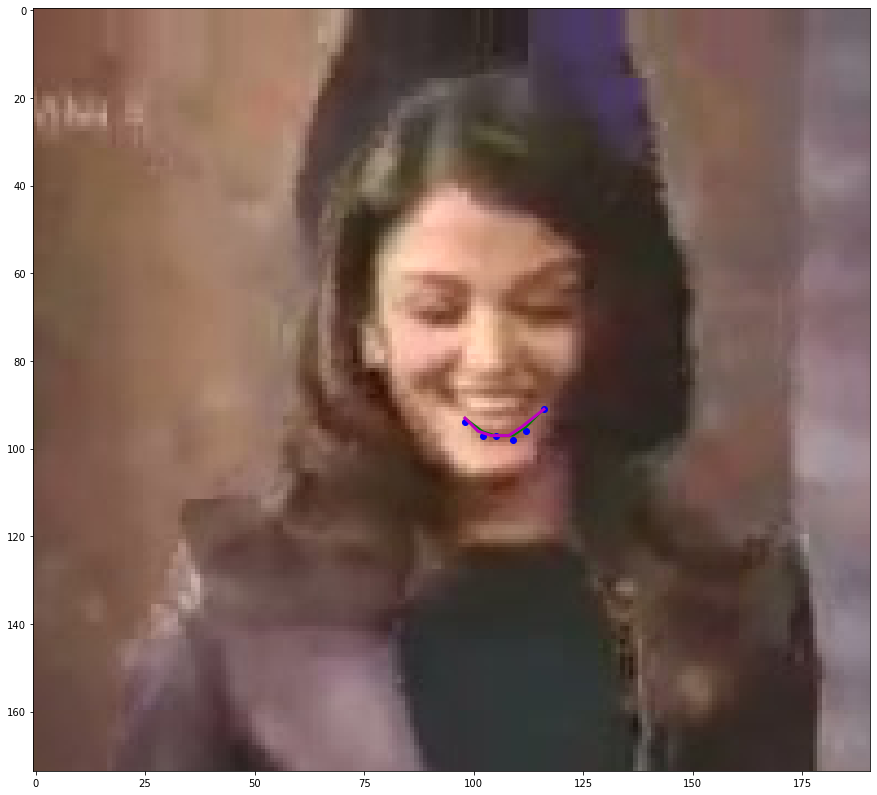

In [18]:
# 1585 - smile
# 3372 - big smile
# 1979 - Neutral
# 339 - Sad
image, mouth, x, y, x_rotated, y_rotated = getMouthCurvature(1585)
emoj, res = getSmile(x_rotated, y_rotated)
print(emoj)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

ax.scatter(mouth[:,0], mouth[:,1],c='blue')
ax.plot(x,y, linewidth=2.0, c='g')
ax.plot(x_rotated,y_rotated, linewidth=3.0 ,c='m')

plt.imshow(image)
plt.show()

## Swap Faces

In [19]:
def faceMask(image, key_pts, e_sizeh=0, e_sizew=0):
    img_masked = np.copy(image)
    nose = key_pts[29,:]
    head = key_pts[0:16,:]
    if e_sizeh == 0 == e_sizew: h, w = (max(head[:,0]) - nose [0]) * 1.1, (max(head[:,1]) - nose [1]) * 1.1
    else: h, w  = e_sizeh, e_sizew
    
    center = (int(nose[0]), int(nose[1]))
    axes = (int(h) , int(w)) # first, second
    angle = 0 #getAngleImage(key_pts)
    color = (0, 177, 64) # green color in RGB

    img_masked=cv2.ellipse(img_masked, center , axes, angle, 0., 360, color , -1)
    
    return img_masked, h, w, center

In [20]:
def prepareImageSwap(n, e_sizeh=0, e_sizew=0):
  IMAGE_SIZE = 224

  image = cv2.imread(os.path.join('data/training/', key_pts_frame.iloc[n, 0]))
  scale = [IMAGE_SIZE / image.shape[1], IMAGE_SIZE / image.shape[0]]
  image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_CUBIC)
  key_pts = key_pts_frame.iloc[n, 1:].values.astype('float').reshape(-1, 2)
  key_pts *= scale
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_masked, h, w, center = faceMask(image, key_pts, e_sizeh, e_sizew)

  mask = cv2.inRange(image_masked, (0,177,64), (0,177,64))
  face_img = np.copy(image)
  face_img[mask == 0] = [0, 0, 0]

  return image, key_pts, mask, h, w, center

In [23]:
def swapTwoFaces(n1, n2):
  image1, key_pts1, mask1, h, w, center1 = prepareImageSwap(n1)
  image2, key_pts2, mask2, _, _, center2 = prepareImageSwap(n2, h, w)

  diffx, diffy = center1[0] - center2[0], center1[1] - center2[1]
  colx, coly = np.zeros((abs(diffx),image2.shape[1], 3)), np.zeros((image2.shape[0],abs(diffy), 3))

  if diffx > 0: face_img2_moved = np.vstack([colx, image2[:-diffx,:,:]])
  else:         face_img2_moved = np.vstack([image2[-diffx:,:,:], colx])
  if diffy > 0: face_img2_moved = np.hstack([coly, face_img2_moved[:,:-diffy,:]])
  else:         face_img2_moved = np.hstack([face_img2_moved[:,-diffy:,:], coly])

  diffx *= -1; diffy *= -1

  if diffx > 0: face_img1_moved = np.vstack([colx, image1[:-diffx,:,:]])
  else:         face_img1_moved = np.vstack([image1[-diffx:,:,:], colx])
  if diffy > 0: face_img1_moved = np.hstack([coly, face_img1_moved[:,:-diffy,:]])
  else:         face_img1_moved = np.hstack([face_img1_moved[:,-diffy:,:], coly])

  ind1 = np.argwhere(mask1 == 255)
  ind2 = np.argwhere(mask2 == 255)
  image_masked1 = np.copy(image1)
  image_masked2 = np.copy(image2)

  for i in range(3):
    image_masked1[ind1[:,0], ind1[:,1] ,i] = face_img2_moved[ind1[:,0],ind1[:,1],i]
    image_masked2[ind2[:,0], ind2[:,1] ,i] = face_img1_moved[ind2[:,0],ind2[:,1],i]

  return image_masked1, image_masked2


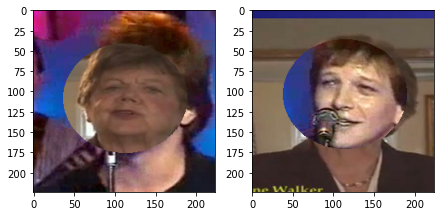

In [24]:
img1, img2 = swapTwoFaces(1615, 2488)

fig = plt.figure(figsize=(15, 15))
plt.subplot(241)
plt.imshow((img1).astype(np.uint8))
plt.subplot(242)
plt.imshow((img2).astype(np.uint8))

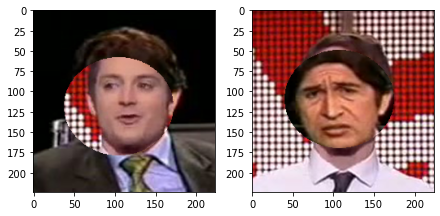

In [25]:
img1, img2 = swapTwoFaces(25, 248)

fig = plt.figure(figsize=(15, 15))
plt.subplot(241)
plt.imshow((img1).astype(np.uint8))
plt.subplot(242)
plt.imshow((img2).astype(np.uint8))

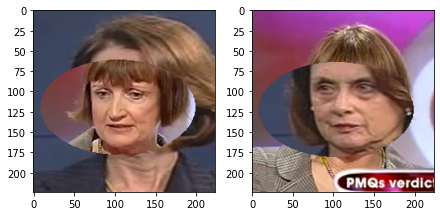

In [26]:
img1, img2 = swapTwoFaces(211, 338)

fig = plt.figure(figsize=(15, 15))
plt.subplot(241)
plt.imshow((img1).astype(np.uint8))
plt.subplot(242)
plt.imshow((img2).astype(np.uint8))

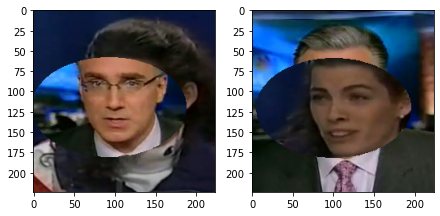

In [27]:
img1, img2 = swapTwoFaces(532, 849)

fig = plt.figure(figsize=(15, 15))
plt.subplot(241)
plt.imshow((img1).astype(np.uint8))
plt.subplot(242)
plt.imshow((img2).astype(np.uint8))

## K-Means - Face Positions

In [90]:
def getImagePose(n):
    image_name = key_pts_frame.iloc[n, 0]
    image_ori = mpimg.imread(os.path.join('data/training/', image_name))
    key_pts = key_pts_frame.iloc[n, 1:].values.astype('float').reshape(-1, 2)
    image = np.copy(image_ori)

    # Based on Tuturial
    # https://learnopencv.com/head-pose-estimation-using-opencv-and-dlib/

    NOSE_TIP    = key_pts[29,:]
    CHIN        = key_pts[8,:]
    LEFT_EYE    = key_pts[36,:]
    RIGHT_EYE   = key_pts[45,:]
    LEFT_MOUTH  = key_pts[48,:]
    RIGHT_MOUTH = key_pts[54,:]
    size = image.shape
    image_points = np.vstack([NOSE_TIP, CHIN, LEFT_EYE, RIGHT_EYE, LEFT_MOUTH, RIGHT_MOUTH])

    # Camera internals - unchanged from Tutorial
    focal_length = size[1]
    center = (size[1] // 2, size[0] // 2)
    camera_matrix = np.array(
                             [[focal_length, 0, center[0]],
                             [0, focal_length, center[1]],
                             [0, 0, 1]], dtype = "double"
                             )
    # 3D model points. - unchanged from Tutorial
    model_points = np.array([
                                (0.0, 0.0, 0.0),             # Nose tip
                                (0.0, -330.0, -65.0),        # Chin
                                (-225.0, 170.0, -135.0),     # Left eye left corner
                                (225.0, 170.0, -135.0),      # Right eye right corne
                                (-150.0, -150.0, -125.0),    # Left Mouth corner
                                (150.0, -150.0, -125.0)      # Right mouth corner

                            ])

    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

    # Project a 3D point (0, 0, 1000.0) onto the image plane.
    # We use this to draw a line sticking out of the nose

    (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)

    for p in image_points:
        cv2.circle(image, (int(p[0]), int(p[1])), 3, (0,0,255), -1)

    p1 = ( int(image_points[0][0]), int(image_points[0][1]))
    p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))

    cv2.line(image, p1, p2, (255,0,0), 2)

    return image_ori, image, rotation_vector, translation_vector, p1, p2


### Examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rotation:  [-3.4652693129848697, -0.0432876675072348, 0.22841610016602662]
translation:  [-13.46449073854118, -69.00542885149633, 1422.6547515479738]


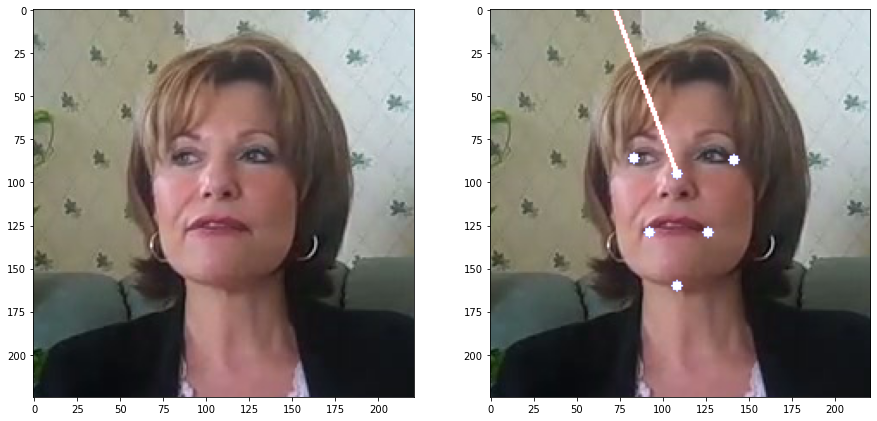

In [53]:
image_ori, image, rotation_vector, translation_vector = getImagePose(23)
fig = plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(image_ori)
plt.subplot(122)
plt.imshow(image)

rotation_vector = np.array(rotation_vector).reshape(1,3).ravel()
translation_vector = np.array(translation_vector).reshape(1,3).ravel()

print('rotation: ', [c for c in rotation_vector])
print('translation: ', [c for c in translation_vector])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rotation:  [-3.065580560582194, -0.00301570823070013, -0.627907735235281]
translation:  [220.78753251268844, 46.90853004489182, 1477.5722926329784]


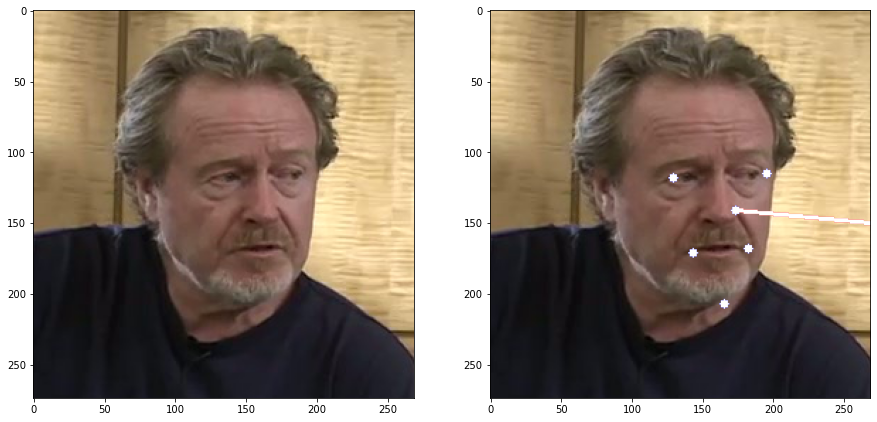

In [54]:
image_ori, image, rotation_vector, translation_vector = getImagePose(233)
fig = plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(image_ori)
plt.subplot(122)
plt.imshow(image)

rotation_vector = np.array(rotation_vector).reshape(1,3).ravel()
translation_vector = np.array(translation_vector).reshape(1,3).ravel()

print('rotation: ', [c for c in rotation_vector])
print('translation: ', [c for c in translation_vector])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rotation:  [0.18358830866476789, 2.239054473042186, -0.018433870215839615]
translation:  [104.01524045153282, -82.6868403891969, -1365.8570377816768]


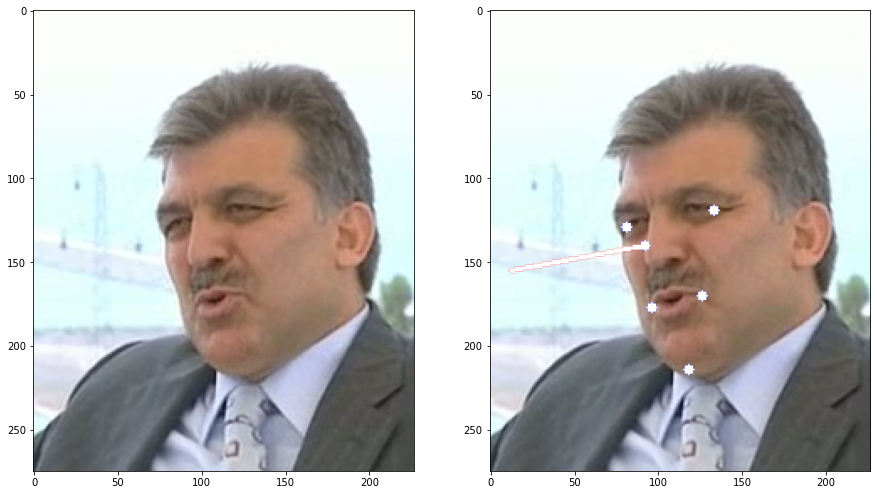

In [59]:
image_ori, image, rotation_vector, translation_vector = getImagePose(368)
fig = plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(image_ori)
plt.subplot(122)
plt.imshow(image)

rotation_vector = np.array(rotation_vector).reshape(1,3).ravel()
translation_vector = np.array(translation_vector).reshape(1,3).ravel()

print('rotation: ', [c for c in rotation_vector])
print('translation: ', [c for c in translation_vector])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rotation:  [-3.5220472749316514, -0.12782854533905105, 0.007174353362493713]
translation:  [9.280059010815714, 4.4123618082586376, 1327.076305571677]


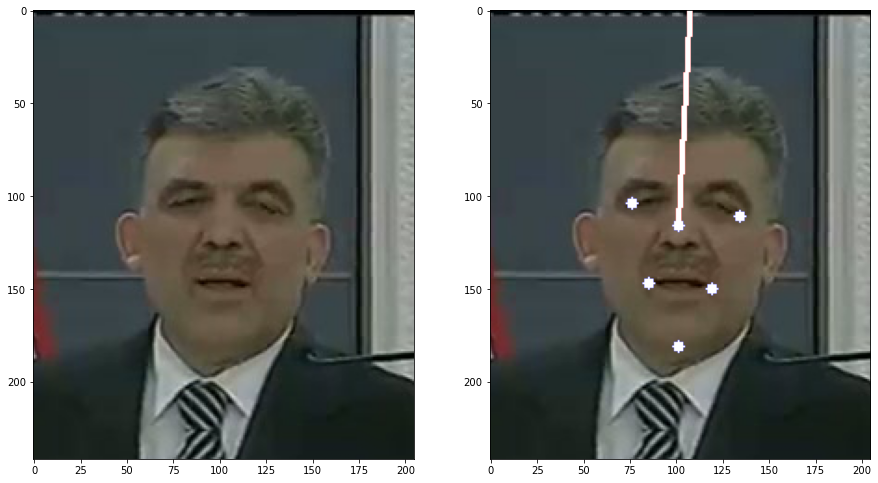

In [62]:
image_ori, image, rotation_vector, translation_vector = getImagePose(663)
fig = plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(image_ori)
plt.subplot(122)
plt.imshow(image)

rotation_vector = np.array(rotation_vector).reshape(1,3).ravel()
translation_vector = np.array(translation_vector).reshape(1,3).ravel()

print('rotation: ', [c for c in rotation_vector])
print('translation: ', [c for c in translation_vector])

### Rst

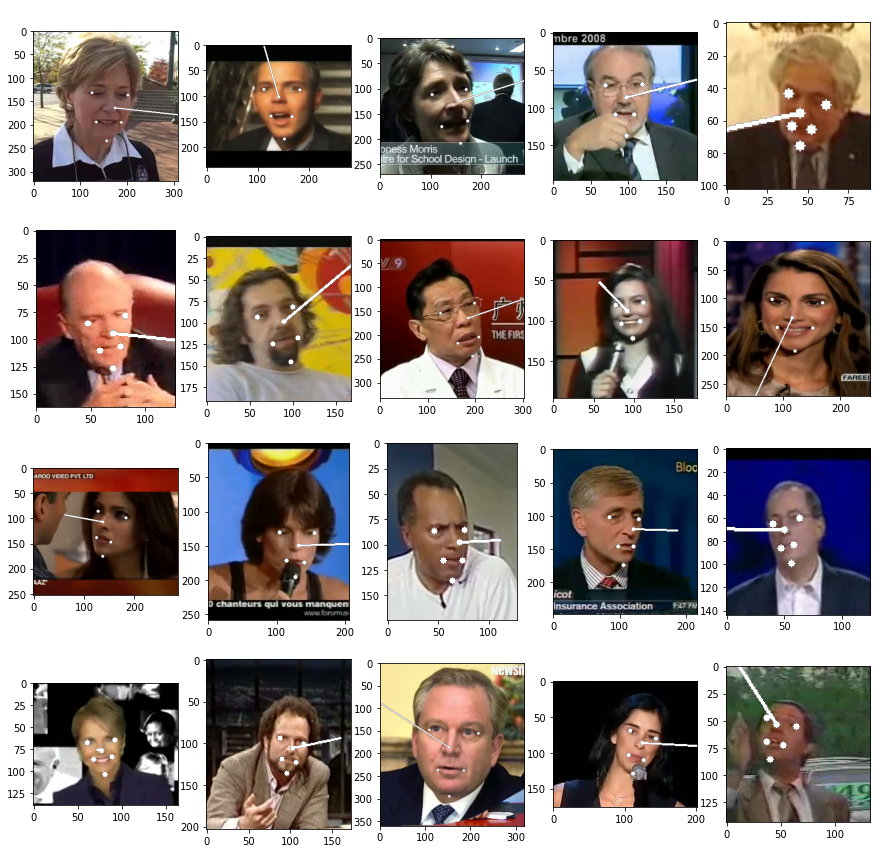

In [98]:
threshold = 9
fig = plt.figure(figsize=(15, 15))
for n in range(20):
    i = np.random.randint(0, 3462)
    image_ori, image, rotation_vector, translation_vector, pNose, pObs = getImagePose(i)
    diffx, diffy  = pObs[0] - pNose[0], pObs[1] - pNose[1]

    pos = 'Looking '
    if -threshold < diffx < threshold: pos += 'Central '
    elif diffx < 0: pos += 'Left '
    else:  pos += 'Right '

    if -threshold < diffy < threshold: pos += 'to center image'
    elif diffy < 0: pos += 'Upwards'
    else:  pos += 'Downwards'
        
    plt.subplot(4,5,n +1)
    plt.title(pos, color='w')
    plt.imshow((image * 255).astype(np.uint8))
    
    

In [63]:
key_pts_frame.shape

(3462, 137)

In [65]:
i = np.random.randint(0, 3462)
i

1363